# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


ModuleNotFoundError: No module named 'matplotlib_venn'

# Read and clean data

Import your data, either through an API or manually, and load it. 

In [3]:
# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi


# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import pandas as pd
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/g9/q3t9r2bx0bdg9g0lrb95lhzh0000gn/T/pip-req-build-kiohls7h
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/g9/q3t9r2bx0bdg9g0lrb95lhzh0000gn/T/pip-req-build-kiohls7h
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
#Load the data from Statistik Banken
ind = DstApi('HFUDD11') 

#Set the language to english
tabsum = ind.tablesummary(language='en')


# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params


# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(ind.variable_levels(variable, language='en'))

display(tabsum)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2023-03-30T08:00:00
BOPOMR:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,101,Copenhagen
3,147,Frederiksberg
4,155,Dragør
...,...,...
100,773,Morsø
101,840,Rebild
102,787,Thisted
103,820,Vesthimmerlands


HERKOMST:


,id,text
0,TOT,Total
1,5,Persons of Danish origin
2,4,Immigrants
3,3,Descendant


HFUDD:


,id,text
0,TOT,Total
1,H10,H10 Primary education
2,H1001,H1001 No education
3,H1010,H1010 Primary school through to 6th grade
4,H1020,H1020 Primary school 7th-9th grade
...,...,...
88,H8080,H8080 PhD programmes
89,H8090,"H8090 Health science, PhD"
90,H8097,"H8097 Higher education not specified, PhD"
91,H90,H90 Not stated


ALDER:


,id,text
0,TOT,"Age, total"
1,15-19,15-19 years
2,20-24,20-24 years
3,25-29,25-29 years
4,30-34,30-34 years
5,35-39,35-39 years
6,40-44,40-44 years
7,45-49,45-49 years
8,50-54,50-54 years
9,55-59,55-59 years


KØN:


,id,text
0,TOT,Total
1,M,Men
2,K,Women


Tid:


,id,text
0,2008,2008
1,2009,2009
2,2010,2010
3,2011,2011
4,2012,2012
5,2013,2013
6,2014,2014
7,2015,2015
8,2016,2016
9,2017,2017


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BOPOMR,105,000,All Denmark,851,Aalborg,False
1,HERKOMST,4,TOT,Total,3,Descendant,False
2,HFUDD,93,TOT,Total,H9099,H9099 Not stated,False
3,ALDER,12,TOT,"Age, total",65-69,65-69 years,False
4,KØN,3,TOT,Total,K,Women,False
5,Tid,15,2008,2008,2022,2022,True


In [6]:


# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params

variables = params['variables'] # Returns a view, that we can edit
#We are only looking at people from Copenhagen, Thisted and Aalborg
variables[0]["values"] = ["101","787", "851"]
#We don't write anything to variables[1], and therefore, we are looking at people across all "Herkomst"
#We are looking at, how many people have a bachelor degree
variables[2]['values'] =['H60']
#We don't look at people with a specific age. But only at Age,total. 
variables[3]["values"] = ["TOT"]
#We are only looking at people with the gender male and female
variables[4]['values'] = ['M', "K"]
#We don't write anything for variables[5], and therefore, we are looking at people across all dates from 2008 to 2022.
params

#Use the variables set above
ind_api = ind.get_data(params=params)

#Sort values for BOPOMR, HFDD, KØN and TID
ind_api.sort_values(by=['BOPOMR', 'HFUDD', "KØN", "TID"], inplace=True)
ind_api.head(5)

# d. drop the columns "HERKOMST"
for v in ['HERKOMST']: 
    del ind_api[v]


#e. rename the columns
ind_api = ind_api.rename(columns = {'INDHOLD':'population w. BA', 'BOPOMR': 'municipality', "ALDER":"age", "KØN": "gender"})

# f. drop non-municipality
for val in ['Region', 'All']: 
    I = ind_api['municipality'].str.contains(val)
    ind_api.drop(ind_api[I].index, inplace=True)


# f. convert to date
ind_api['date'] = pd.PeriodIndex(ind_api.TID,freq='Q').to_timestamp() # Convert to datetime
del ind_api['TID']
del ind_api["age"]
del ind_api["HFUDD"]

#Show the cleaned table
ind_api.head(10)



,municipality,gender,population w. BA,date
15,Aalborg,Men,8,2008-01-01
17,Aalborg,Men,175,2008-01-01
19,Aalborg,Men,1724,2008-01-01
21,Aalborg,Men,1907,2008-01-01
37,Aalborg,Men,9,2009-01-01
39,Aalborg,Men,172,2009-01-01
41,Aalborg,Men,1763,2009-01-01
43,Aalborg,Men,1944,2009-01-01
59,Aalborg,Men,17,2010-01-01
61,Aalborg,Men,207,2010-01-01


In [7]:

# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params

variables = params['variables'] # Returns a view, that we can edit
#We are only looking at people from Copenhagen, Thisted and Aalborg
variables[0]["values"] = ["101","787", "851"]
#We don't write anything to variables[1], and therefore, we are looking at people across all "Herkomst"
#We are looking at, how many people have a bachelor degree
variables[2]['values'] =['H60']
#We don't look at people with a specific age. But only at Age,total. 
variables[3]["values"] = ["TOT"]
#We are only looking at people with the gender male and female
variables[4]['values'] = ['M', "K"]
#We don't write anything for variables[5], and therefore, we are looking at people across all dates from 2008 to 2022.
params

#Use the variables set above
ind_api = ind.get_data(params=params)

#Sort values for BOPOMR, HFDD, KØN and TID
ind_api.sort_values(by=['BOPOMR', 'HFUDD', "KØN", "TID"], inplace=True)
ind_api.head(5)

# d. drop the columns "HERKOMST"
for v in ['HERKOMST']: 
    del ind_api[v]


#e. rename the columns
ind_api = ind_api.rename(columns = {'INDHOLD':'population w. BA', 'BOPOMR': 'municipality', "ALDER":"age", "KØN": "gender", "TID" :"year"})

# f. drop non-municipality
for val in ['Region', 'All']: 
    I = ind_api['municipality'].str.contains(val)
    ind_api.drop(ind_api[I].index, inplace=True)


# f. convert to date
del ind_api["age"]
del ind_api["HFUDD"]

#Show the cleaned table
ind_api.head(10)


ind_api.head(10)

,municipality,gender,year,population w. BA
15,Aalborg,Men,2008,8
17,Aalborg,Men,2008,175
19,Aalborg,Men,2008,1724
21,Aalborg,Men,2008,1907
37,Aalborg,Men,2009,9
39,Aalborg,Men,2009,172
41,Aalborg,Men,2009,1763
43,Aalborg,Men,2009,1944
59,Aalborg,Men,2010,17
61,Aalborg,Men,2010,207


Below is the code for table INDKP106 of DST. The data has been cleaned to contain average wages in DKK for our chosen municipalities for men and women in the years 2008-2022.  

In [8]:
ind = DstApi('INDKP106') 

tabsum = ind.tablesummary(language='en')

# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params

variables = params['variables'] # Returns a view, that we can edit
#We are only looking at people from Copenhagen, Thisted and Aalborg and choosing average wage in 1000 dkk
variables[0]["values"] = ["101","787", "851"]
variables[1]['values'] = ["118"]
#We are looking at all ages and men and women
variables[2]['values'] =["M", "K"]
variables[3]["values"] = ["00"]
#We are looking at all income intervals and years 2008-2022
variables[4]['values'] = ["000"]
variables[5]['values']= ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
params


ind_api = ind.get_data(params=params)
ind_api.head(5)

ind_api.sort_values(by=["OMRÅDE", 'ENHED', "KOEN", 'ALDER1',"INDKINTB", "TID", "INDHOLD"], inplace=True)
ind_api.head(5)


#change names
ind_api = ind_api.rename(columns = {"OMRÅDE":"municipality", "ENHED":"Avg. in DKK", "KOEN":"Gender", "ALDER1":"age", "INDKINTB":"Income Interval", "TID":"year", "INDHOLD":"AVG. Income"})

# e. drop non-municipalities
for val in ['Region', 'All']: 
    I = ind_api['municipality'].str.contains(val)
    ind_api.drop(ind_api[I].index, inplace=True)


# f. convert to date
ind_api['date'] = pd.PeriodIndex(ind_api.year,freq='Q').to_timestamp() # Convert to datetime
del ind_api['date']
del ind_api['Avg. in DKK']
del ind_api['Income Interval']
del ind_api['age']
ind_api.head(10)


Table INDKP106: Disposable income by region, unit, sex, age, income interval and time
Last update: 2023-11-27T08:00:00


,municipality,Gender,year,AVG. Income
5,Aalborg,Men,2008,180336
11,Aalborg,Men,2009,182936
17,Aalborg,Men,2010,198016
23,Aalborg,Men,2011,202401
29,Aalborg,Men,2012,206446
35,Aalborg,Men,2013,211651
41,Aalborg,Men,2014,214205
47,Aalborg,Men,2015,219801
53,Aalborg,Men,2016,222795
59,Aalborg,Men,2017,231397


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


NameError: name 'widgets' is not defined

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

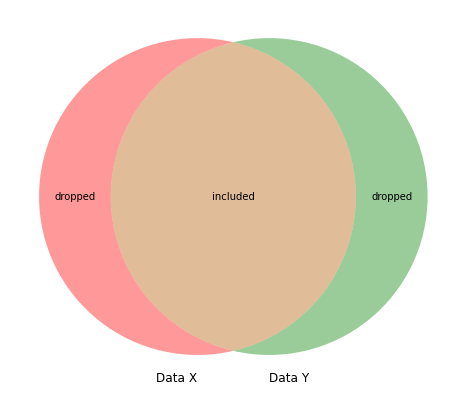

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

To get an overview of how many people who has a bachelors degree in Aalborg, Thisted and Copenhagen, we make a summary statistics:

In [ ]:
ind_api.describe()

,population,date
count,334.000000,334
mean,3264.718563,2015-01-16 10:38:05.029940224
min,1.000000,2008-01-01 00:00:00
25%,66.000000,2011-01-01 00:00:00
50%,429.500000,2015-01-01 00:00:00
75%,2822.250000,2019-01-01 00:00:00
max,18873.000000,2022-01-01 00:00:00
std,5264.556997,NaN


From the table above we see, that in the two cities, 334

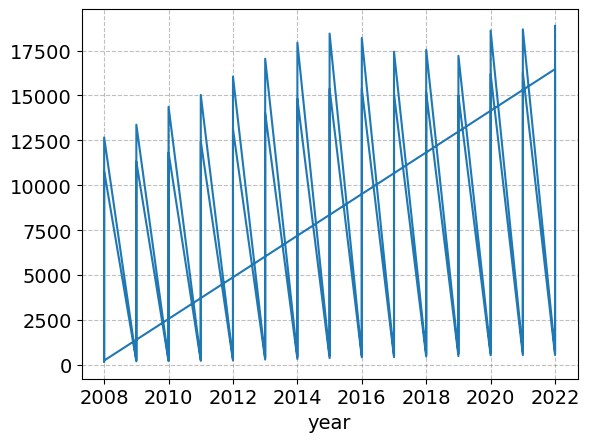

In [ ]:
# Data frame with roskilde
BA_copenhagen = ind_api.loc[ind_api['municipality'] == 'Copenhagen', :]

# Plot the content of the data frame
BA_copenhagen.plot(x='year',y='population w. BA',legend=False);

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.